## Introduction

Import required libraries

In [1]:
%matplotlib inline
import pandas as pd
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from matplotlib import colors
from sklearn.dummy import DummyRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error
from scipy.stats import norm
from sklearn.model_selection import GridSearchCV, KFold, cross_val_predict

Provide the path to the file containing the data

Note I am using a third party graphing library called seaborn, website here - https://seaborn.pydata.org/. To change the background of our graphs we can use the code below

In [2]:
path_to_csv = "data/abalone.csv"       # Load Data
sns.set(rc={'figure.figsize':(11,8)})  # Change all graphs backgrounds

The abalone dataset contains the following attributes.

| <p align="left">Name</p>           | <p align="left">Units</p>   | <p align="left">Description</p>      |
|:-----------------------------------|:-------:|:---------------------------------------------------------|
| <p align="left">Sex</p>            |         | <p align="left">M (male), F (female), and I (infant)</p> |
| <p align="left">Length</p>         | mm      | <p align="left">Longest shell measurement</p>            |
| <p align="left">Diameter</p>       | mm      | <p align="left">Perpendicular to length</p>              |
| <p align="left">Height</p>         | mm      | <p align="left">With meat in shell</p>                   |
| <p align="left">Whole Weight</p>   | grams   | <p align="left">Whole abalone</p>                        |
| <p align="left">Shucked weight</p> | grams   | <p align="left">Weight of meat</p>                       |
| <p align="left">Viscera weight</p> | grams   | <p align="left">Gut weight (after bleeding)</p>          |
| <p align="left">Shell weight</p>   | grams   | <p align="left">After being dried</p>                    |
| <p align="left">Rings</p>          |         | <p align="left">+1.5 gives the age in years</p>          |

We can load the data into a pandas dataframe using the code below. Notice how each column is being assigned a human readable name, this is necessary because in its current form the dataset does not contain any headers. After the loading the data into the dataframe we can print the first 5 rows as outlined in the code below

In [3]:
df = pd.read_csv(path_to_csv, header=None, names = ["Sex", "Length", "Diameter", "Height", "Whole Weight", "Shucked Weight", "Viscera Weight", "Shell Weight", "Rings"])

df.head() # Prints the first 5 rows of our dataframe

,Sex,Length,Diameter,Height,Whole Weight,Shucked Weight,Viscera Weight,Shell Weight,Rings
0,M,0.455,0.365,0.095,0.5140,0.2245,0.1010,0.150,15
1,M,0.350,0.265,0.090,0.2255,0.0995,0.0485,0.070,7
2,F,0.530,0.420,0.135,0.6770,0.2565,0.1415,0.210,9
3,M,0.440,0.365,0.125,0.5160,0.2155,0.1140,0.155,10
4,I,0.330,0.255,0.080,0.2050,0.0895,0.0395,0.055,7


# Missing Data


Lets take a closer look at the data and see if we can detect an missing data. I will be looking for the following types of issues with the data

- Invalid column data types, for example columns that should be numeric but instead contain strings
- Columns that contain missing data. For example null values

Lets start with an analysis of the column data types. Pandas allows us to easily summarize the data structure of the data frame using the code below

In [4]:
df.dtypes

Sex                object
Length            float64
Diameter          float64
Height            float64
Whole Weight      float64
Shucked Weight    float64
Viscera Weight    float64
Shell Weight      float64
Rings              object
dtype: object

Most of the columns are as we would expect. However Rings is meant to be numerical, but pandas is displaying it as an "object". This is likely a case of invalid data throwing pandas off. Using the code below we can convert all data in the row to be numeric and drop anything that isnt numeric.

In [5]:
df['Rings'] = pd.to_numeric(df['Rings'], errors='coerce')
df.dtypes

Sex                object
Length            float64
Diameter          float64
Height            float64
Whole Weight      float64
Shucked Weight    float64
Viscera Weight    float64
Shell Weight      float64
Rings             float64
dtype: object

After re-checking the structure of the pandas data frame we can see that the Rings column is now a float64.

Next lets check for any null values across the entire data frame. We can do this with the code below

In [6]:
nans_predicate = df.isnull().any(axis=1)
nans = df[nans_predicate]
nans

,Sex,Length,Diameter,Height,Whole Weight,Shucked Weight,Viscera Weight,Shell Weight,Rings
878,F,0.635,0.485,0.165,1.2945,0.6680,NaN,0.2715,9.0
1888,F,0.565,0.445,0.125,0.8305,0.3135,0.1785,0.2300,NaN
3093,NaN,0.520,0.430,0.150,0.7280,0.3020,0.1575,0.2350,11.0
3466,M,0.640,0.500,0.170,1.4545,0.6420,0.3575,0.3540,NaN


#### As can be seen from the results of our search we have 4 NaN rows. 

- Row 878 has an invalid Viscera weight
- row 1888 has an invalid Rings value 
- row 3093 has an invalid Sex value
- row 3466 has an invalid Rings value

We can now drop the indexes that are invalid from our dataframe. Before we do that lets display the size of our data frame before and after to confirm that the 4 rows were dropped

In [7]:
print("Before drop count", df.shape)
df.drop(df.index[nans_predicate], inplace=True)    # Drop the data with NaN values
print("After drop count", df.shape)

Before drop count (4177, 9)
After drop count (4173, 9)


# Erroneous Data

Lets now do an analysis to see if we can find any erroneous data. What I will try to do in this section is determine if the data is reasonable from a logical sense. For example abalones cannot have a height of zero, this would be impossible.

Lets start by using the describe feature of pandas to get a quick summary of the data

In [8]:
df.describe()

,Length,Diameter,Height,Whole Weight,Shucked Weight,Viscera Weight,Shell Weight,Rings
count,4173.000000,4173.000000,4173.000000,4173.000000,4173.000000,4173.000000,4173.000000,4173.000000
mean,0.523929,0.407620,0.139504,0.828504,0.359251,0.180538,0.238798,9.933621
std,0.120123,0.100111,0.041842,0.490473,0.221972,0.109625,0.139257,3.225565
min,0.075000,-0.430000,0.000000,0.002000,0.001000,0.000500,0.001500,1.000000
25%,0.450000,0.350000,0.115000,0.441500,0.186000,0.093000,0.130000,8.000000
50%,0.545000,0.425000,0.140000,0.799500,0.336000,0.170500,0.233500,9.000000
75%,0.615000,0.480000,0.165000,1.153000,0.501500,0.252500,0.329000,11.000000
max,0.815000,0.650000,1.130000,2.825500,1.488000,0.760000,1.005000,29.000000


Immediately it is odvious there are a few issues here. 

- Height cannot have a minimum value of zero
- Diameter cannot have a minimum value which is a minus number

Lets check our entire dataset for numbers which are less than or equal to zero.

In [9]:
df[(df.select_dtypes(include=['number']) <= 0).any(1)]

,Sex,Length,Diameter,Height,Whole Weight,Shucked Weight,Viscera Weight,Shell Weight,Rings
1257,I,0.430,0.34,0.000,0.4280,0.2065,0.0860,0.1150,8.0
2758,M,0.535,-0.43,0.155,0.7845,0.3285,0.1690,0.2450,10.0
3996,I,0.315,0.23,0.000,0.1340,0.0575,0.0285,0.3505,6.0


The code above has detected 3 rows containing impossible values. This could be as a result of invalid data entry or some other event, however we need to handle these entries to prevent skewed results later on. 

Theres a few things we could do. 
- We could replace the erroneous values with the mean value of the entire column. For example in the case of the Height column we could get the mean of the Height column and replace the zero with that value. 
- Alternatively we can just drop the rows completely

As there are only 3 rows detected as erroneous it seems reasonable to simply drop them for now. We can do this using the code below

In [10]:
print("Before drop count", df.shape)
df.drop(df.index[df['Height'] <= 0], inplace=True)     # Drop the height erroneous rows
df.drop(df.index[df['Diameter'] <= 0], inplace=True)   # Drop the diameter erroneous rows
print("After drop count", df.shape)

Before drop count (4173, 9)
After drop count (4170, 9)


We have successfully dropped the erroneous rows, next lets make sure all values in our Sex column are upper case for consistency. We will also remove any trailing whitespace which has been put in the Sex column unintentionally 

We have successfully dropped the erroneous rows. Notice above in our df.describe that there is no data on the Sex field. Lets do a few quick transformations to make sure everything is OK with this field. Lets make sure all the data in this field is uppercase and has no whitespace. 

In [11]:
df['Sex'].str.upper()   # Make sure everything in the Sex column is uppercase
df['Sex'].str.strip()   # Strip whitespace from Sex column

for index, row in df.iterrows():
    if row["Sex"] != 'M' and row["Sex"] != 'F' and row["Sex"] != 'I':
        print(row["Sex"])

Everything looks ok with the Sex column. 

Because shucked weight is weight without the shell. We should check if our data contains data where shucked weight is greater than the whole weight, which should not be possible. 

Lets create a scatter plot of shucked weight vs whole weight for quick visual inspection


Text(0.5,1,'Shucked Weight VS Whole Weight')

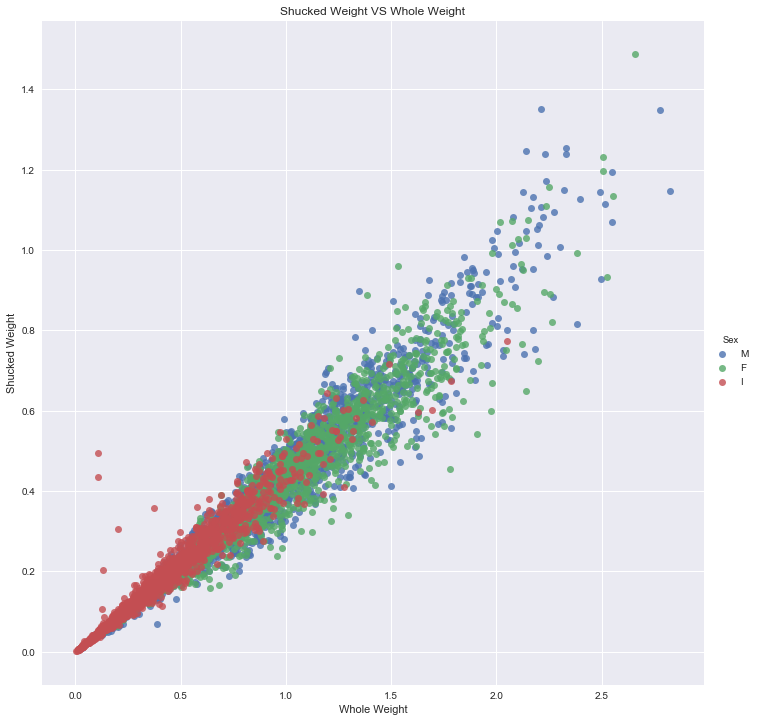

In [12]:
sns.lmplot("Whole Weight", "Shucked Weight", data=df, hue='Sex', fit_reg=False, size=10)
ax = plt.gca()
ax.set_title("Shucked Weight VS Whole Weight")

In the bottom left it seems we have some infants whose shucked weight is greater than the whole weight. 
We can get the exact rows using the formula below

In [13]:
shucked_wight_greater_than_whole = df['Shucked Weight'] > df['Whole Weight']
df[shucked_wight_greater_than_whole]

,Sex,Length,Diameter,Height,Whole Weight,Shucked Weight,Viscera Weight,Shell Weight,Rings
1216,I,0.310,0.225,0.070,0.1055,0.4350,0.0150,0.0400,5.0
2627,I,0.275,0.205,0.070,0.1055,0.4950,0.0190,0.0315,5.0
2641,I,0.475,0.365,0.100,0.1315,0.2025,0.0875,0.1230,7.0
3086,I,0.355,0.270,0.075,0.2040,0.3045,0.0460,0.0595,7.0


Lets remove these rows

In [14]:
print("Before drop count: ", df.shape)
df.drop(df.index[df['Shucked Weight'] > df['Whole Weight']], inplace=True)
print("After drop count: ", df.shape)

Before drop count:  (4170, 9)
After drop count:  (4166, 9)


# Outliers

Here we will try and detect datapoints which are outside the normal distribution. Lets start by creating a boxplot of all the columns

Text(0.5,1,'Box Plot')

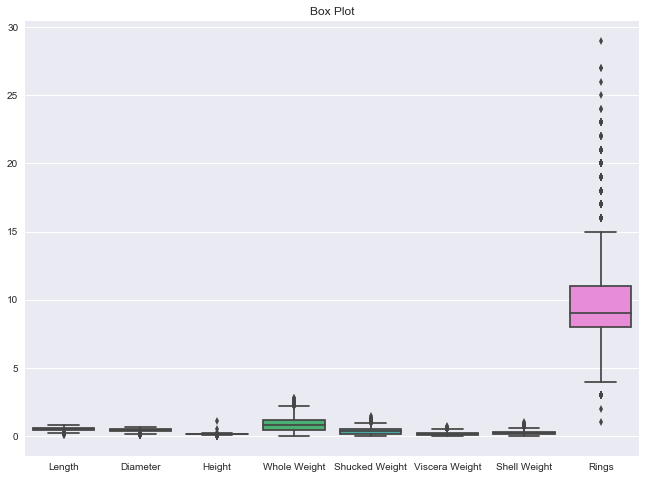

In [15]:
sns.boxplot(data=df).set_title("Box Plot")

This is slightly hard to read as the Rings column takes over much of the graph. Lets work on the Rings on its own to start with

Text(0.5,1,'Box Plot For Rings')

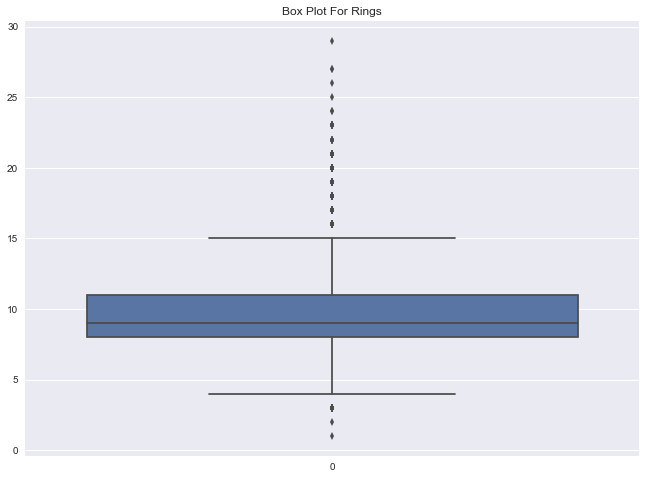

In [16]:
sns.boxplot(data=df['Rings']).set_title("Box Plot For Rings")

In [17]:
rings = df['Rings']

q1 = rings.quantile(0.25)
q3 = rings.quantile(0.75)
iqr = q3 - q1
lw = q1 - 1.5 * iqr
uw = q3 + 1.5 * iqr

outlier_predicate = (df['Rings'] > uw) | (df['Rings'] < lw)

print("Lower:", lw)
print("Upper:", uw)
print("Total outliers:", df[outlier_predicate].count()['Rings'])

Lower: 3.5
Upper: 15.5
Total outliers: 278


There seems to be alot of outliers here. We can choose to drop them or replace them with the median. In this case, because there are so many I would be apprehensive about dropping the rows. I will replace the values with the median. Lets do this below

In [18]:
median = df.loc[outlier_predicate, 'Rings'].median()
df.loc[outlier_predicate, 'Rings'] = np.nan
df.fillna(rings.median(),inplace=True)

If we run the boxplot again we should see that the outliers have been taken care of

Text(0.5,1,'Box Plot For Rings')

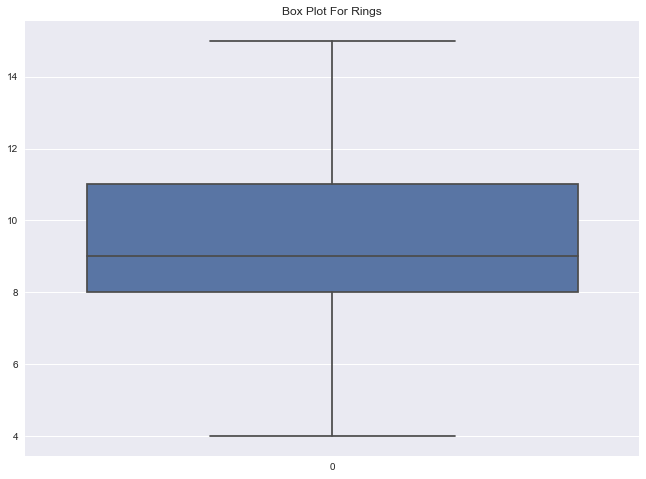

In [19]:
sns.boxplot(data=df['Rings']).set_title("Box Plot For Rings")

Lets run the boxplot again for all the other features minus the Rings. We do this to prevent the Rings column from taking over the graph like we saw above

[Text(0,0.5,'Scores'),
 Text(0.5,0,'Attributes'),
 Text(0.5,1,'Box Plot For Dataset Features')]

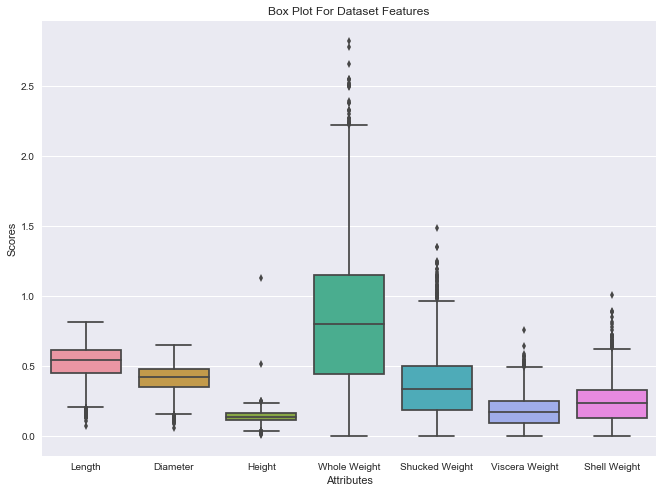

In [20]:
df_ringless=df.drop('Rings',  axis='columns')
ax=sns.boxplot(data=df_ringless)
ax.set(xlabel='Attributes', ylabel='Scores', title="Box Plot For Dataset Features")

Lets go through these one by one and see if we can take care of all the outliers. First lets look at the length column

In [21]:
length = df['Length']

q1 = length.quantile(0.25)
q3 = length.quantile(0.75)
iqr = q3 - q1
lw = q1 - 1.5 * iqr
uw = q3 + 1.5 * iqr

outlier_predicate = (df['Length'] > uw) | (df['Length'] < lw)

print("Lower:", lw)
print("Upper:", uw)
print("Total outliers:", df[outlier_predicate].count()['Length'])

Lower: 0.20250000000000004
Upper: 0.8624999999999999
Total outliers: 49


Only 49 this time. Lets drop those 49 rows from the dataset

In [22]:
print("Before drop count", df.shape)
df.drop(df.index[outlier_predicate], inplace=True) # Drop the rows
print("After drop count", df.shape)

Before drop count (4166, 9)
After drop count (4117, 9)


Lets move onto diameter

In [23]:
diameter = df['Diameter']

q1 = diameter.quantile(0.25)
q3 = diameter.quantile(0.75)
iqr = q3 - q1
lw = q1 - 1.5 * iqr
uw = q3 + 1.5 * iqr

outlier_predicate = (df['Diameter'] > uw) | (df['Diameter'] < lw)

print("Lower:", lw)
print("Upper:", uw)
print("Total outliers:", df[outlier_predicate].count()['Diameter'])

Lower: 0.15499999999999997
Upper: 0.675
Total outliers: 12


Only 12 this time. Lets drop those 12 rows from the dataset

In [24]:
print("Before drop count", df.shape)
df.drop(df.index[outlier_predicate], inplace=True) # Drop the rows
print("After drop count", df.shape)

Before drop count (4117, 9)
After drop count (4105, 9)


Next lets look at the height outliers

In [25]:
height = df['Height']

q1 = height.quantile(0.25)
q3 = height.quantile(0.75)
iqr = q3 - q1
lw = q1 - 1.5 * iqr
uw = q3 + 1.5 * iqr

outlier_predicate = (df['Height'] > uw) | (df['Height'] < lw)

print("Lower:", lw)
print("Upper:", uw)
print("Total outliers:", df[outlier_predicate].count()['Height'])

Lower: 0.039999999999999994
Upper: 0.24000000000000002
Total outliers: 6


Lets drop the 6 rows

In [26]:
print("Before drop count", df.shape)
df.drop(df.index[outlier_predicate], inplace=True) # Drop the rows
print("After drop count", df.shape)

Before drop count (4105, 9)
After drop count (4099, 9)


Next up is the Whole Weight column

In [27]:
whole_weight = df['Whole Weight']

q1 = whole_weight.quantile(0.25)
q3 = whole_weight.quantile(0.75)
iqr = q3 - q1
lw = q1 - 1.5 * iqr
uw = q3 + 1.5 * iqr

outlier_predicate = (df['Whole Weight'] > uw) | (df['Whole Weight'] < lw)

print("Lower:", lw)
print("Upper:", uw)
print("Total outliers:", df[outlier_predicate].count()['Whole Weight'])

Lower: -0.6014999999999996
Upper: 2.2164999999999995
Total outliers: 28


Lets drop the 28 rows

In [28]:
print("Before drop count", df.shape)
df.drop(df.index[outlier_predicate], inplace=True) # Drop the rows
print("After drop count", df.shape)

Before drop count (4099, 9)
After drop count (4071, 9)


Next up is Shucked Weight column

In [29]:
shucked_weight = df['Shucked Weight']

q1 = shucked_weight.quantile(0.25)
q3 = shucked_weight.quantile(0.75)
iqr = q3 - q1
lw = q1 - 1.5 * iqr
uw = q3 + 1.5 * iqr

outlier_predicate = (df['Shucked Weight'] > uw) | (df['Shucked Weight'] < lw)

print("Lower:", lw)
print("Upper:", uw)
print("Total outliers:", df[outlier_predicate].count()['Shucked Weight'])

Lower: -0.273875
Upper: 0.9651249999999999
Total outliers: 25


Lets drop the 46 rows

In [30]:
print("Before drop count", df.shape)
df.drop(df.index[outlier_predicate], inplace=True) # Drop the rows
print("After drop count", df.shape)

Before drop count (4071, 9)
After drop count (4046, 9)


In [31]:
viscera_weight = df['Viscera Weight']

q1 = viscera_weight.quantile(0.25)
q3 = viscera_weight.quantile(0.75)
iqr = q3 - q1
lw = q1 - 1.5 * iqr
uw = q3 + 1.5 * iqr

outlier_predicate = (df['Viscera Weight'] > uw) | (df['Viscera Weight'] < lw)

print("Lower:", lw)
print("Upper:", uw)
print("Total outliers:", df[outlier_predicate].count()['Viscera Weight'])

Lower: -0.13425
Upper: 0.47975
Total outliers: 16


Lets drop the 16 rows

In [32]:
print("Before drop count", df.shape)
df.drop(df.index[outlier_predicate], inplace=True) # Drop the rows
print("After drop count", df.shape)

Before drop count (4046, 9)
After drop count (4030, 9)


Finally we can move onto the Shell Weight column

In [33]:
shell_weight = df['Shell Weight']

q1 = shell_weight.quantile(0.25)
q3 = shell_weight.quantile(0.75)
iqr = q3 - q1
lw = q1 - 1.5 * iqr
uw = q3 + 1.5 * iqr

outlier_predicate = (df['Shell Weight'] > uw) | (df['Shell Weight'] < lw)

print("Lower:", lw)
print("Upper:", uw)
print("Total outliers:", df[outlier_predicate].count()['Shell Weight'])

Lower: -0.15324999999999994
Upper: 0.6087499999999999
Total outliers: 28


Lets drop the 30 rows and run our boxplot again to see if all the outliers have been taken care of

In [34]:
print("Before drop count", df.shape)
df.drop(df.index[outlier_predicate], inplace=True) # Drop the rows
print("After drop count", df.shape)

Before drop count (4030, 9)
After drop count (4002, 9)


[Text(0,0.5,'Scores'),
 Text(0.5,0,'Attributes'),
 Text(0.5,1,'Box Plot For Dataset Features')]

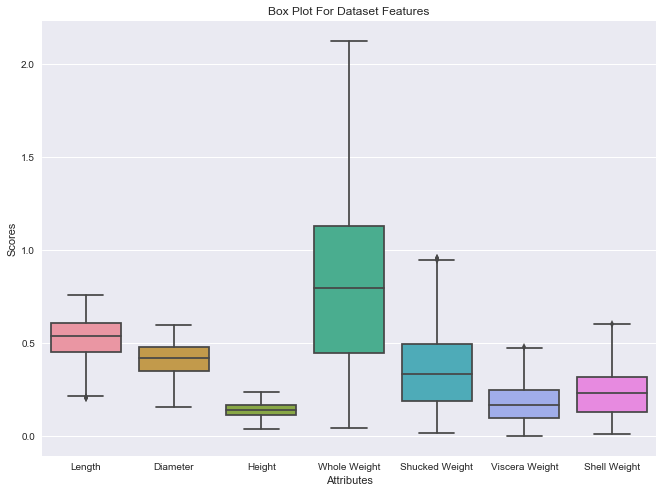

In [35]:
df_ringless=df.drop('Rings',  axis='columns')
ax=sns.boxplot(data=df_ringless)
ax.set(xlabel='Attributes', ylabel='Scores', title="Box Plot For Dataset Features")

# Scatter Plot

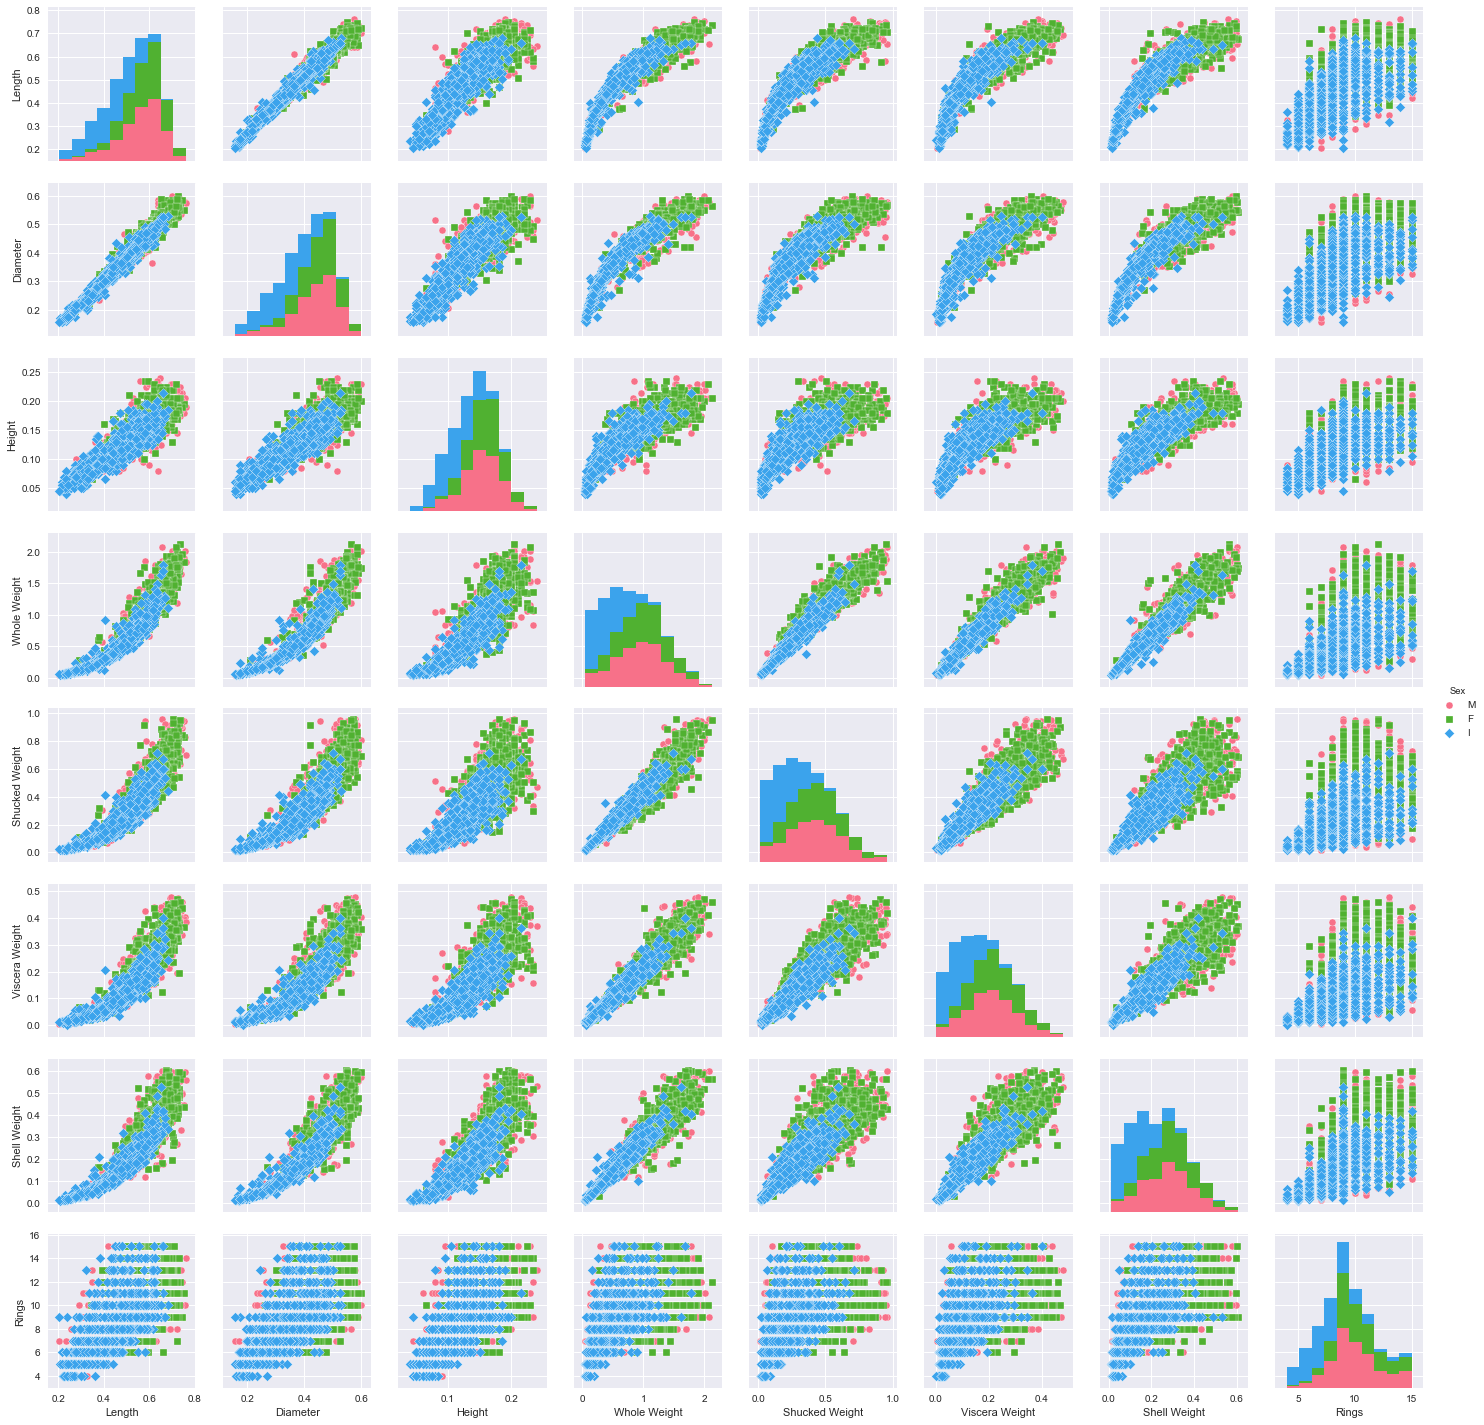

In [36]:
sns.pairplot(df, hue="Sex", palette="husl", markers=["o", "s", "D"])

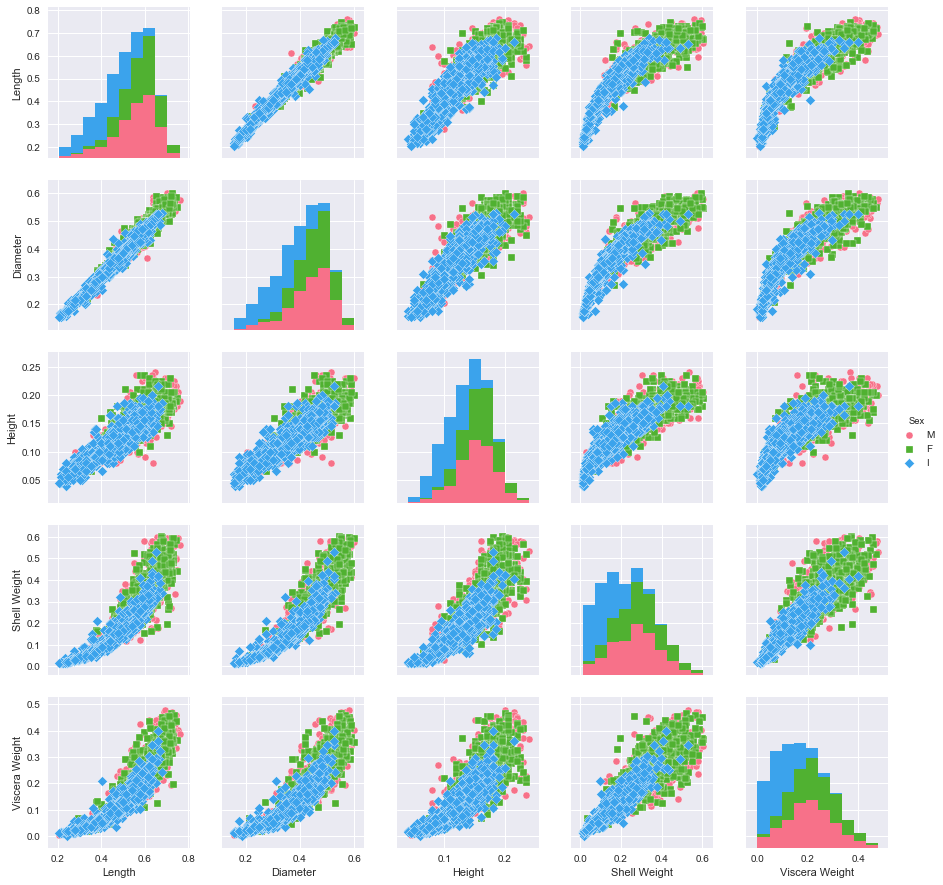

In [37]:
sns.pairplot(df[['Sex', 'Length', 'Diameter', 'Height', 'Shell Weight', 'Viscera Weight']], hue="Sex", palette="husl", markers=["o", "s", "D"])

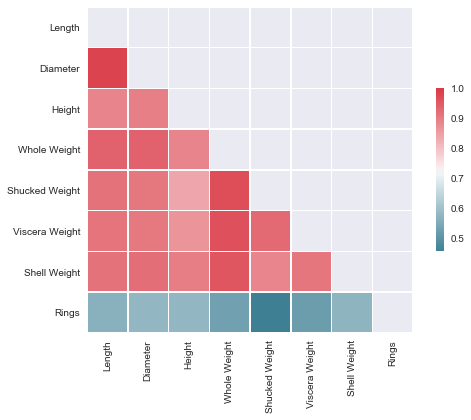

In [38]:
corr = df.corr()
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
f, ax = plt.subplots(figsize=(8, 6))
cmap = sns.diverging_palette(220, 10, as_cmap=True)
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=1,square=True, linewidths=.5, cbar_kws={"shrink": .5}, ax=ax);

In [39]:
#corr = df[['Sex', 'Length', 'Diameter', 'Height', 'Shell Weight', 'Viscera Weight']].corr()
#c1 = corr.abs().unstack()
#c1.sort_values(ascending = False)

def get_redundant_pairs(df):
    '''Get diagonal and lower triangular pairs of correlation matrix'''
    pairs_to_drop = set()
    cols = df.columns
    for i in range(0, df.shape[1]):
        for j in range(0, i+1):
            pairs_to_drop.add((cols[i], cols[j]))
    return pairs_to_drop

def get_top_abs_correlations(df, n=5):
    au_corr = df.corr().abs().unstack()
    labels_to_drop = get_redundant_pairs(df)
    au_corr = au_corr.drop(labels=labels_to_drop).sort_values(ascending=False)
    return au_corr[0:n]

print("Top Absolute Correlations")
print(get_top_abs_correlations(df[['Length', 'Diameter', 'Height', 'Whole Weight', 'Shucked Weight', 'Viscera Weight', 'Shell Weight', 'Rings']], 20))

Top Absolute Correlations
Length          Diameter          0.985479
Whole Weight    Shucked Weight    0.969603
                Viscera Weight    0.964788
                Shell Weight      0.958027
Length          Whole Weight      0.940114
Diameter        Whole Weight      0.939257
Shucked Weight  Viscera Weight    0.928357
Diameter        Shell Weight      0.923355
Length          Shell Weight      0.915653
                Shucked Weight    0.915316
                Viscera Weight    0.912786
Viscera Weight  Shell Weight      0.912392
Diameter        Shucked Weight    0.908892
                Viscera Weight    0.908134
Height          Shell Weight      0.898131
Diameter        Height            0.896162
Height          Whole Weight      0.891351
Length          Height            0.889514
Shucked Weight  Shell Weight      0.888020
Height          Viscera Weight    0.867896
dtype: float64


# Linear Regression Model

Lets build a regression model for the abalone dataset. The regression model will predict the number of rings of an abalone

### One hot encoding

Because regression can only work on numeric values we are going to have to use a technique called one hot encoding to convert our Sex column into numeric data

In [40]:
df['Sex'].unique()

array(['M', 'F', 'I'], dtype=object)

In [41]:
encoded_sex = pd.get_dummies(df['Sex'])
df = pd.concat([df, encoded_sex], axis='columns')
df = df.drop('Sex', axis='columns')

df.head()

,Length,Diameter,Height,Whole Weight,Shucked Weight,Viscera Weight,Shell Weight,Rings,F,I,M
0,0.455,0.365,0.095,0.5140,0.2245,0.1010,0.150,15.0,0,0,1
1,0.350,0.265,0.090,0.2255,0.0995,0.0485,0.070,7.0,0,0,1
2,0.530,0.420,0.135,0.6770,0.2565,0.1415,0.210,9.0,1,0,0
3,0.440,0.365,0.125,0.5160,0.2155,0.1140,0.155,10.0,0,0,1
4,0.330,0.255,0.080,0.2050,0.0895,0.0395,0.055,7.0,0,1,0


Notice the Sex column has been dropped and we now see 3 new columns for the sex. These are M, F, I (Male, Female, Infant). 

### Dummy model
Next lets prepare a dummy regression model. As mentioned in the lab notes, these are very naive (often incorrect) predictions about the target variable. This is a good first step as it gives us a benchmark to compare our later models to.

Mean absolute error: 1.777231
Standard deviation of the error: 2.260731


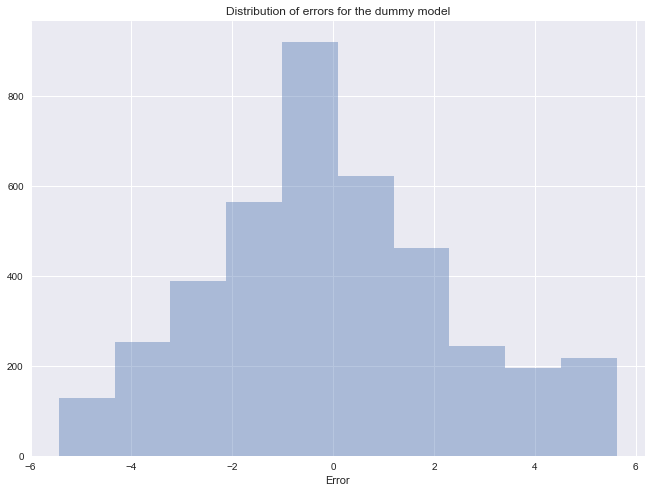

In [42]:
X = df.drop('Rings', axis='columns')  # X = features
y = df['Rings']                       # y = prediction target
model = DummyRegressor()
outer_cv = KFold(n_splits=5, shuffle=True, random_state=0)  # 5 fold cross validation
y_pred = cross_val_predict(model, X, y, cv=outer_cv)        # Make predictions via cross validation

print('Mean absolute error: %f' % mean_absolute_error(y, y_pred))
print('Standard deviation of the error: %f' % (y - y_pred).std())

ax = sns.distplot(y - y_pred, bins=10, kde=False)

ax.set(
    title='Distribution of errors for the dummy model',
    xlabel='Error'
);

### Linear regression model

Mean absolute error: 1.330730
Standard deviation of the error: 1.720256


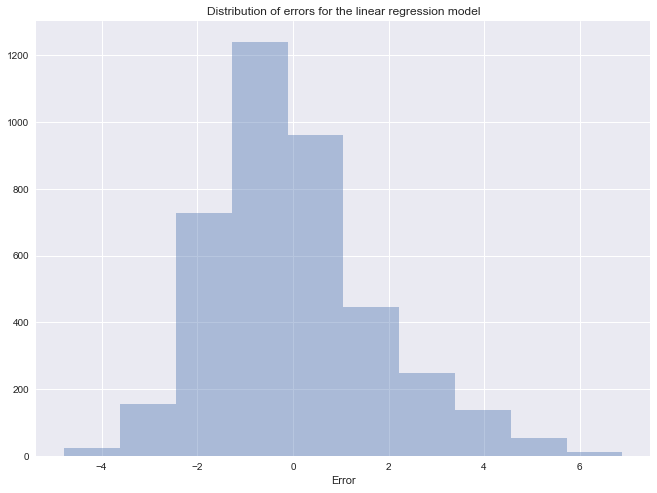

In [43]:
X = df.drop('Rings', axis='columns')  # X = features
y = df['Rings']                       # y = prediction target

model = LinearRegression(fit_intercept=True, normalize=False)  # Use least squares linear regression

outer_cv = KFold(n_splits=5, shuffle=True, random_state=0)  # 5-fold cross validation
y_pred = cross_val_predict(model, X, y, cv=outer_cv)        # Make predictions via cross validation

print('Mean absolute error: %f' % mean_absolute_error(y, y_pred))
print('Standard deviation of the error: %f' % (y - y_pred).std())

ax = sns.distplot(y - y_pred, bins=10, kde=False)
ax.set(
    title='Distribution of errors for the linear regression model',
    xlabel='Error'
);